# 뉴스 요약 하기 


**텍스트 요약**

긴 길이의 문서를 핵심 주제만으로 구성된 짧은 요약 문장들로 반환하는 것을 말한다 
요약할때 정보 손실을 최소화 해야한다 

두가지 접근 방법 

1. 추출적 요약(Extractive Summarization)
    > 문장들을 추출해서 요약하는 방식 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식인데 꺼내온 3개가 중요한것일수는 있어도 문장의 연결이 자연스럽지 않을수있다 그래서 딥러닝 보다는 전통적인 머신러닝 방식에 속하는 텍스트 랭크와 같은 알고리즘을 사용해서 이 방법 사용한다 -> 네이버 뉴스 요약봇 서비스 
    -> 원문 구성하는 문장중 어느 것이 요약문에 들어갈 핵심 문장인지 판별하는 문장 분류 
    
   
2. 추상적 요약(Abstractive Summarization)
    > 새로운 문장을 생성해 내는것 


RNN,LSTM , GRU 같은것은 장기 의존성 문제가 있어서 Attention이 나옴   


지금 뉴스 이건 지도 학습이다 






# Attention  Mechanism 

인코더의 모든 step의 hidden state의 정보가 context vector에 전부 반영되도록 한것이다 -> 동일한 비중이 아니라 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산 된다 -> 가중치와의 차이점 



kaggle에서 제공된 아마존 리뷰 데이터셋을 사용할것이다 

56만개의 데이터로 이루어져 있다 10만개의 샘플만 사용해 본다 


Text내용을 입력 받으면 summary를 예측하도록 할것이다 



NLTK는 Natural Language Toolkit의 축약어 -> 설치 필요 하다 
100개의 불용어가 미리 정리 되어있다 

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
#10만개의 샘플만 사용해 본다 
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [4]:
# text와 summary정보만 볼것이다 
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

Text  \
57304  Unlike many flavored coffees - this tastes lik...   
34600  I love spicy snacks and was looking for someth...   
4292   This is one of the best GLUTEN-FREE mix on the...   
90427  I've had Jamaican Blue Mountain coffee before ...   
59989  I remember as kid having malt shakes (back the...   
83310  This is a great deal, and a great coffee. I dr...   
27804  The time for delivery was fast and I'm very sa...   
69579  I was introduced to Stash a few years ago when...   
87362  If you are tired of spending 5 bucks at the lo...   
70171  I am a fan of Lipton Iced Green Tea so when I ...   
90527  Wanting to make our own safe popcorn...we boug...   
22079  I followed all the instructions and great guid...   
50424  The product is exactly what I wanted.  The spe...   
47412  Bilberry taste a lot like the berry of similar...   
21951  In my search for a toy that would occupy & cha...   

                                     Summary  
57304                            Very yummy!  
34600                     Outright dangerous  
4292                               Wonderful  
90427                     Good but not Great  
59989                    Best malt I've had!  
83310                           Great Coffee  
27804              Amazing price and service  
69579            A Favorite Morning Beverage  
87362        Maeda-en Sweet Green Tea Powder  
70171           Just What the Doctor Ordered  
90527  Organic Popcorn. Best we ever popped!  
22079          My dog never figured this out  
50424                                Altoids  
47412                               Its Okay  
21951                     Just a Jug, No Tug

# preprocesing 

summary는 중복 될수있다 텍스트 달라도 동일할수있으니까 하지만 text는 중복되면 안된다



* nunique() : 고유한것의 개수 알려주는 함수이다 





In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다

data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
# 결측치 확인하기 

print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
#Summary 1개 삭제 하기 
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


# Text normalization [텍스트 정규화 ]


In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


# 불용어 처리 하기


NLTK 다운 받은 불용어이다 

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

"""
불용어를 무조건 제거하는게 아니라 revmove stopwords flag를 통해 제한한다 왜냐하면 
추상적인 요약문 만들때 불용어 남아 있는게 더 좋을수있다 

그러니까 summary 전처리 할때 불용어 없애지 않으려고 하는것이다 



"""

print('=3')

=3


In [12]:
# 정의한 함수가 작동 되는지 확인하기 


temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

# 영어만 잘 남아있다 

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [13]:
# 모든 텍스트에 대해 전처리 적용 하기 
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [14]:
# 모든 summary에 대해 전처리 적용 하기 

clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [15]:
# 데이터들 전치리 한 이후에 결측값 생겼을수도 있으니까 확인하는 작업이다 

data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [17]:
# 결측치 제거 하기 10만개 중에 70개 정도는 버릴만한것 같다 
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


# Split train test data

학습 진행하기 위해서는 학습에 사용할 데이터 크기 결정하고 문장의 시작과 끝 표시 해야함 즉 SOS EOS token 필요 하다는 의미이다 


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


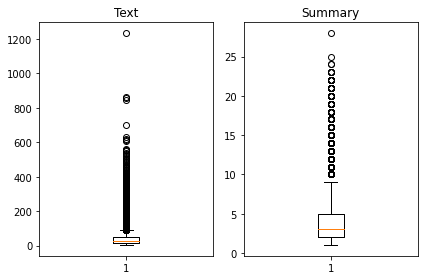

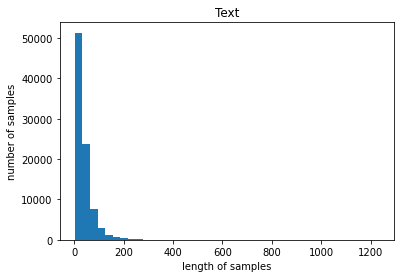

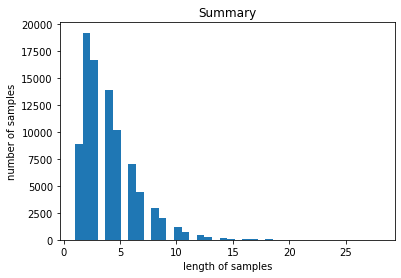

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 임시로 이렇게 설정했을때 비율을 확인해 보기 위함이다 
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [20]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [22]:
# 데이터를 날리는데 실습에서는 더 나은 방법으로 진행? tokenizer사용해도 
# 똑같을려나? -> maxlen에 대한 표준편차 자료 더 필용할듯 
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


In [23]:

# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

Text                Summary  \
0  bought several vitality canned dog food produc...  good quality dog food   
1  product arrived labeled jumbo salted peanuts p...      not as advertised   
2  confection around centuries light pillowy citr...    delight says it all   
3  looking secret ingredient robitussin believe f...         cough medicine   
4  great taffy great price wide assortment yummy ...            great taffy   

                    decoder_input                  decoder_target  
0  sostoken good quality dog food  good quality dog food eostoken  
1      sostoken not as advertised      not as advertised eostoken  
2    sostoken delight says it all    delight says it all eostoken  
3         sostoken cough medicine         cough medicine eostoken  
4            sostoken great taffy            great taffy eostoken

In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [25]:
from sklearn.model_selection import train_test_split

encoder_input_train,encoder_input_test = train_test_split(encoder_input,test_size=0.2,shuffle=True)
decoder_input_train,decoder_input_test=train_test_split(decoder_input,test_size=0.2,shuffle=True)
decoder_target_train,decoder_target_test=train_test_split(decoder_target,test_size=0.2,shuffle=True)

print(len(encoder_input_train))
print(len(encoder_input_test))
print(len(decoder_input_train))
print(len(decoder_input_test))


52654
13164
52654
13164


# Tokenizer 정의 하기 


### Tokenizer fit on text는 속성값인 word_index에 저장 되어있다 
### 우선 fit on text를 하면 word_index도 있고 word_counts등 이 많이 있다 이런걸 사용해야 직접적으로 사용 가능하다 


texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

print('=3')

=3


In [27]:
print(len(encoder_input_train))
print(len(src_tokenizer.word_index))

52654
31970


# 단어의 빈도수를 보고 전처리 한다 


In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31970
등장 빈도가 6번 이하인 희귀 단어의 수: 23731
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8239
단어 집합에서 희귀 단어의 비율: 74.22896465436347
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.379816464674997


**6회 미만의 단어들은 단어 집합에서 70%정도 하지만 테스트 데이터 등장 빈도 차지 비중은 상대적으로 3.39%이다 그래서 제거 한다** 



In [29]:
# 다시 tokenizer 재정의 한다 
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print(len(src_tokenizer.word_index))
print(len(encoder_input_train))
print('=3')

31970
52654
=3


In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환 texts to sequence 

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[301, 28, 368, 2461, 21, 186, 1569, 5687, 156, 240, 977, 2827, 170, 33, 11, 649], [1772, 22, 1357, 4656, 279, 1055, 214, 303, 155, 1906, 7643, 566, 207, 5, 356, 128, 464, 1132, 1521, 1447, 1357, 537, 655, 245, 445, 4656, 155, 70, 160, 2176, 1190, 78, 956, 4656, 78, 862], [129, 35, 265, 1397, 1143, 31, 1500, 306, 29, 265, 191, 143, 646, 2, 5, 3526, 18, 1559, 1253, 306, 29, 29, 10, 82, 143, 514, 37, 184, 808, 77, 1684, 12, 3, 265, 191, 40, 1016]]


In [31]:
# Summary에 대해서도 같은 작업 

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print(len(tar_tokenizer.word_index))
print(len(decoder_input_train))

10463
52654


In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10463
등장 빈도가 5번 이하인 희귀 단어의 수: 8073
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2390
단어 집합에서 희귀 단어의 비율: 77.15760298193635
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.847233811928461


text와 마찬가지로 비율을 본것인데 테스트 데이터 기준으로 보면 약 5%정도의 비율이니까 동일하게 단어 제거 한다 

단어 집합 크기가 2000이 안됨 그래도 일단 그렇다고 하고 진행 하겠다


In [33]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 36, 63], [1, 7, 93, 14, 611, 46, 5, 299], [1, 55, 3, 66], [1, 15, 19], [1, 116, 1235, 405]]
target
decoder  [[3, 16, 2], [565, 5, 729, 426, 2], [1047, 206, 1934, 2], [2], [17, 2]]


빈도수가 낮은 단어가 삭제 되었다는 것은 빈도수가 낮은 단어만으로 구성 되었던 샘플들은 이제 빈 샘플이 되었을 가능성이 있다 

In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1] # 토큰만 있는 경우
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1] # 토큰만 있는 경우 

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1254
삭제할 테스트 데이터의 개수 : 330
훈련 데이터의 개수 : 51400
훈련 레이블의 개수 : 51400
테스트 데이터의 개수 : 12834
테스트 레이블의 개수 : 12834


# padding 하기 

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


# 모델 평가 하기 


input(shpae,batch_size.,.,,


shape:배치 크기를 포함하지 않는 모양 튜플 (정수). 예를 들어 shape=(32,) 는 예상 입력이 32 차원 벡터의 배치임을 나타냅니다. 이 튜플의 요소는 None이 될 수 있습니다. '없음'요소는 모양이 알려지지 않은 치수를 나타냅니다.


<br>
</br>

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.  
  
LSTM 3개의 층으로 구성했다   

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요. 즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.  

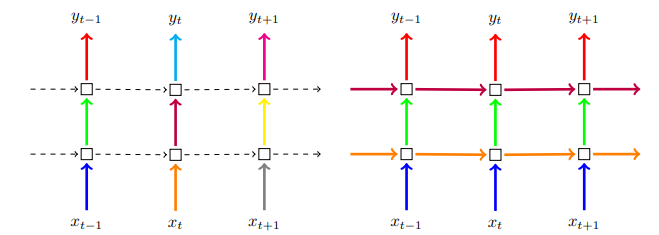

참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 해요. 오른쪽 그림 

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

#Attention 위한 encoder 개선 

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # 모든 시점의 은닉 상태가 반환된다 그래서 말이됨 

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 지금까지는 seq2seq구조 이다 이제 Attention사용 할것이다 


어텐션 함수는 Bahdanau 스타일의 어텐션입니다

인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 모델 훈련 하기 

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)  

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.    
monitor:	Quantity to be monitored  

patience는 각 train할때 patience만큼 ephoc 변화 없으면 멈추는 역할 한다   

train validataion 그래프 그렸을때 갈라지는 지점에서 멈추는 역할 하는건가?


In [40]:
#validation_data=([encoder_input_test, decoder_input_test],decoder_target_test)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_split=0.2, \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
161/161 [==============================] - 19s 76ms/step - loss: 3.0312 - val_loss: 2.9262
Epoch 2/50
161/161 [==============================] - 11s 70ms/step - loss: 2.8985 - val_loss: 2.9058
Epoch 3/50
161/161 [==============================] - 11s 69ms/step - loss: 2.8835 - val_loss: 2.9182
Epoch 4/50
161/161 [==============================] - 11s 69ms/step - loss: 2.8718 - val_loss: 2.9051
Epoch 5/50
161/161 [==============================] - 11s 68ms/step - loss: 2.8639 - val_loss: 2.9041
Epoch 6/50
161/161 [==============================] - 11s 68ms/step - loss: 2.8550 - val_loss: 2.9333
Epoch 7/50
161/161 [==============================] - 11s 68ms/step - loss: 2.8463 - val_loss: 2.9199
Epoch 00007: early stopping


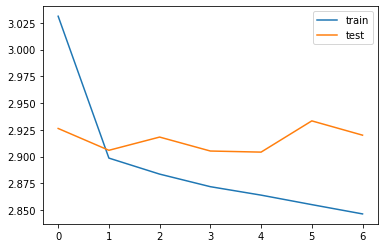

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현 하기 


훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


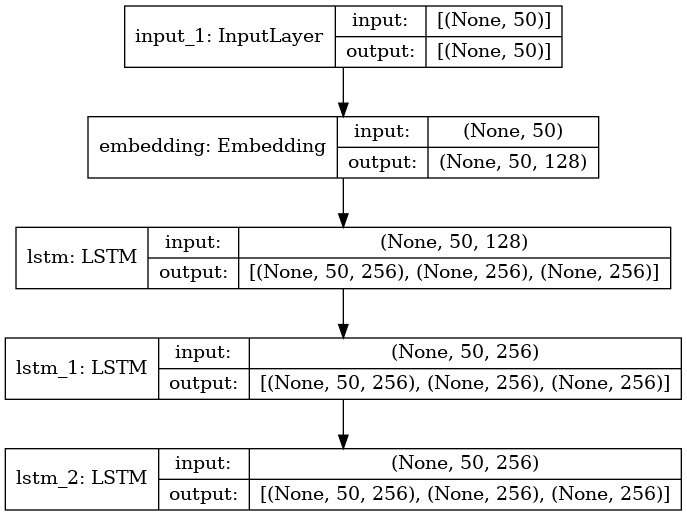

In [43]:
from tensorflow.keras.utils import plot_model
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

plot_model(encoder_model,show_shapes=True)

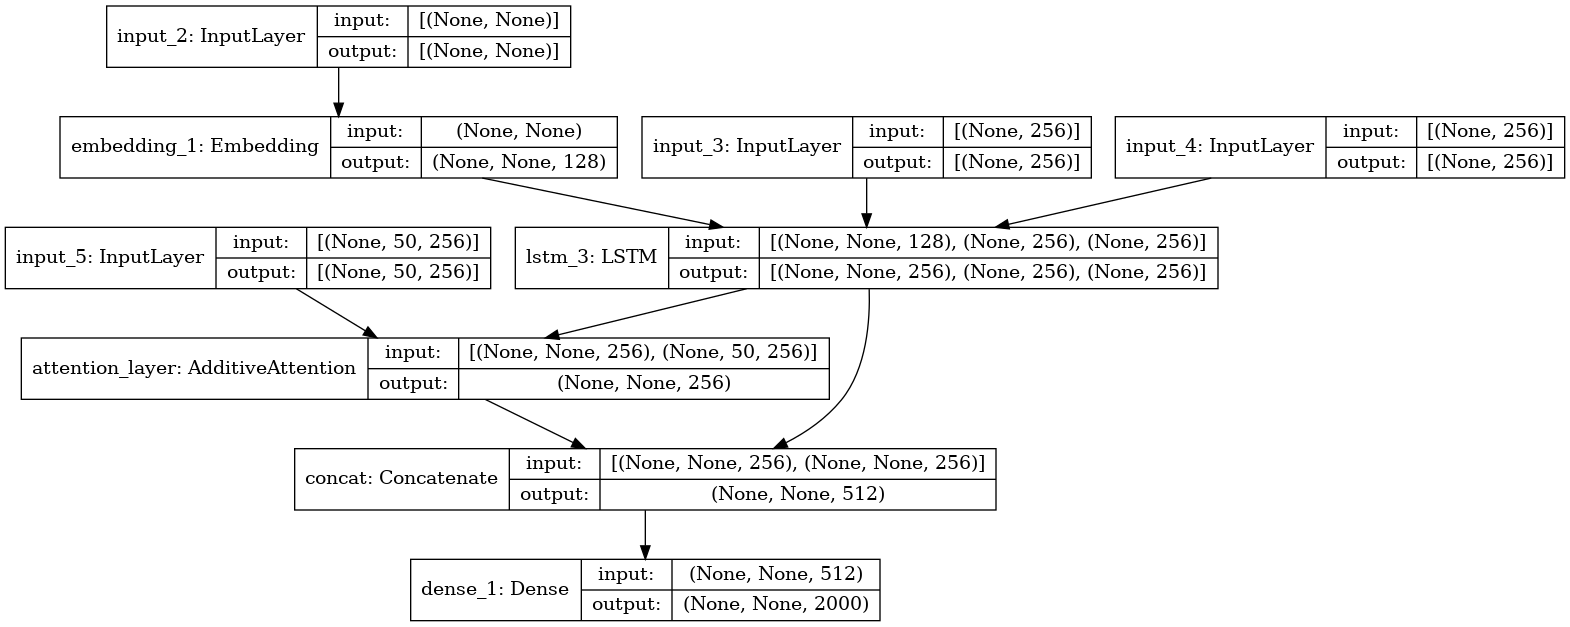

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

plot_model(decoder_model,show_shapes=True)

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : seriously bad taste matter tastes bad bought orange horrible taste even put bottle gallon orange juice takes bad let alone put whole bottle gallon mix crystal light waste money 
실제 요약 : tasted yuk 
예측 요약 :  great


원문 : love snack snyder cheddar cheese pretzel pieces ounce packages cannot find locally amazon go store ordering easy convenient price comparable stores delivery quick 
실제 요약 : is in the vet 
예측 요약 :  great


원문 : ginger lemon drink foil packet instant powder needs cup boiling water make hot tasty flavorful drink honey already included excellent feel throat coming think like much 
실제 요약 : coffee from eight of the clock 
예측 요약 :  great


원문 : fits kuerig pike place starbucks favorite say happy arrived fast complete good packaging 
실제 요약 : harney and sons paris tea 
예측 요약 :  great


원문 : great product mom cats love best thing different flavors amount get price would recommend also ordering line best experience leave house great price quick delivery thanks 
실제 요약 : tasty 


# 뉴스 기사 요약해보기 


In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

headlines  \
26293  Friday the 13th to witness supermoon solar ecl...   
36754  Afghanistan accuses Pakistan of cross-border a...   
66518  Reach office by 9:45 AM or face action: Delhi ...   
80929  Scrap Kashmir's special status in 8 days: Shiv...   
20341  Shareholder proposes luxury cars, Maruti Chair...   
64763  Geoffrey Boycott faced the first-ever ball of ...   
16827  Won't hesitate to call some JNU forces anti-In...   
97756  Israeli plane, tank strikes hit Gaza after roc...   
37064  Depressed retired judge shoots himself in the ...   
69614  TV serial makers respond to row over actor pla...   

                                                    text  
26293  Parts of Australia will witness a partial sola...  
36754  Afghanistan on Thursday accused Pakistan of ca...  
66518  The Delhi government's Women and Child Develop...  
80929  The Shiv Sena has urged the PM Narendra Modi-l...  
20341  A Maruti Suzuki shareholder on Thursday sugges...  
64763  Former England batsman Geoffrey Boycott played...  
16827  Union Defence Minister Nirmala Sitharaman said...  
97756  The Israeli military has responded with air an...  
37064  A 76-year-old retired district judge allegedly...  
69614  The makers of the TV serial 'Taarak Mehta Ka O...

# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

# Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [5]:
data.shape

(98401, 2)

In [6]:
len(data)

98401

In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
print(data.isnull().sum())


headlines    0
text         0
dtype: int64


In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [13]:
# 확인하기 
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [14]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


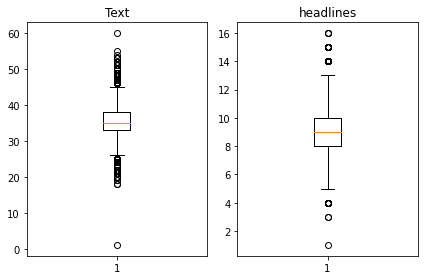

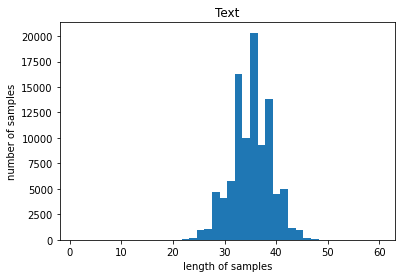

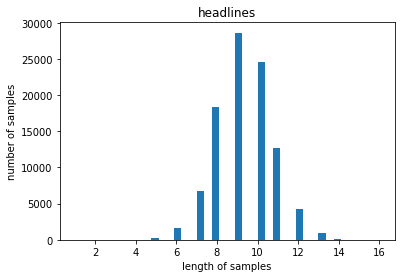

In [19]:
# 길이 분포 출력
# 샘플 최대 길이 정하기 


import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 37

summary_max_len = 9


In [21]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 37 이하인 샘플의 비율: 0.7378304188694591
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.5666022773485156


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 40912


In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

headlines  \
3   aegon life iterm insurance plan helps customer...   
10  up cousins fed human excreta for friendship wi...   
18  how long can tolerate congress leaders potshot...   
19  odisha cm patnaik controls mining mafia union ...   
20  think the opposition even dreams about me pm modi   

                                                 text  \
3   aegon life iterm insurance plan customers enjo...   
10  two minor cousins uttar pradesh gorakhpur alle...   
18  days threatened step post congress mlas contin...   
19  union minister dharmendra pradhan wednesday cl...   
20  claiming dearth ideas among opposition parties...   

                                        decoder_input  \
3   sostoken aegon life iterm insurance plan helps...   
10  sostoken up cousins fed human excreta for frie...   
18  sostoken how long can tolerate congress leader...   
19  sostoken odisha cm patnaik controls mining maf...   
20  sostoken think the opposition even dreams abou...   

                                       decoder_target  
3   aegon life iterm insurance plan helps customer...  
10  up cousins fed human excreta for friendship wi...  
18  how long can tolerate congress leaders potshot...  
19  odisha cm patnaik controls mining mafia union ...  
20  think the opposition even dreams about me pm m...

In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [26]:
from sklearn.model_selection import train_test_split

encoder_input_train,encoder_input_test = train_test_split(encoder_input,test_size=0.2,shuffle=True)
decoder_input_train,decoder_input_test=train_test_split(decoder_input,test_size=0.2,shuffle=True)
decoder_target_train,decoder_target_test=train_test_split(decoder_target,test_size=0.2,shuffle=True)

print(len(encoder_input_train))
print(len(encoder_input_test))
print(len(decoder_input_train))
print(len(decoder_input_test))


32729
8183
32729
8183


In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
src_tokenizer
print(len(encoder_input_train))
print(len(src_tokenizer.word_index))

32729
47294


In [28]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 47294
등장 빈도가 5번 이하인 희귀 단어의 수: 31875
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15419
단어 집합에서 희귀 단어의 비율: 67.39755571531273
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.470716792784641


In [29]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(len(encoder_input_train))
# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

32729
[[437, 217, 189, 244, 2336, 2761, 1272, 7, 52, 730, 2406, 415, 11, 21, 3712, 424, 437, 217, 144, 1336, 43, 7, 84, 991, 1499, 154, 34, 338, 1272, 89, 282, 217, 1479, 1336], [312, 1375, 312, 798, 2504, 850, 4, 700, 12081, 404, 6423, 128, 48, 6424, 798, 2019, 4771, 312, 768, 2054, 2856, 312, 12082, 10609, 49, 1, 6, 805, 3243, 312, 7046, 1452, 3479, 2207], [693, 2536, 585, 512, 130, 2314, 3161, 4672, 1509, 1097, 480, 11298, 12962, 887, 645, 1487, 14071, 71, 14072, 4855, 12083, 3004, 2536, 585, 1, 4564, 69, 3665, 4672, 11298, 4672, 1290, 4856, 2601, 2208, 12962]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print(len(tar_tokenizer.word_index))
print(len(decoder_input_train))

21835
32729


In [32]:
threshold = 3
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 21835
등장 빈도가 2번 이하인 희귀 단어의 수: 11599
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10236
단어 집합에서 희귀 단어의 비율: 53.12113579116098
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.8415157762050445


In [33]:
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3957, 108, 693, 6074, 12, 1174, 5, 129], [1, 1837, 3342, 569, 2922, 671, 7, 89, 1932, 9788], [1, 54, 118, 148, 242, 803, 1766, 42], [1, 3809, 1799, 1552, 1163, 10726, 4, 7393, 647, 2093], [1, 335, 4, 2582, 2583, 2846, 13, 916]]
target
decoder  [[5373, 2813, 722, 16, 5, 90, 1393, 1381, 2], [91, 1397, 525, 25, 7493, 2480, 2], [30, 298, 6449, 7929, 4, 74, 7116, 3165, 2], [3378, 2944, 2416, 4, 19, 642, 6954, 2], [1438, 135, 17, 958, 9507, 1027, 2415, 2]]


In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 32729
훈련 레이블의 개수 : 32729
테스트 데이터의 개수 : 8183
테스트 레이블의 개수 : 8183


In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


# 모델 설계 


In [62]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 300
hidden_size = 100

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.3, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout = 0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [63]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True,dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 37, 300)      4500000     input_8[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 37, 100), (N 160400      embedding_4[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

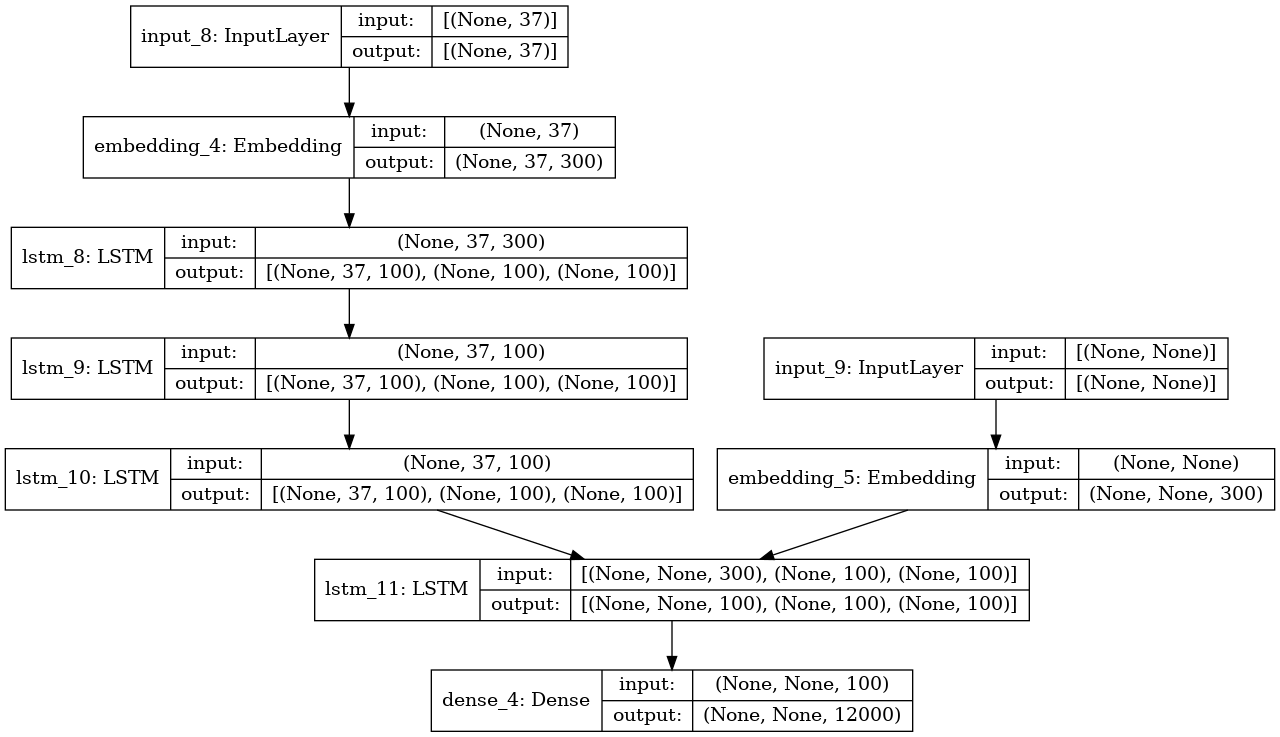

In [64]:
import tensorflow as tf
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 37, 300)      4500000     input_8[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 37, 100), (N 160400      embedding_4[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

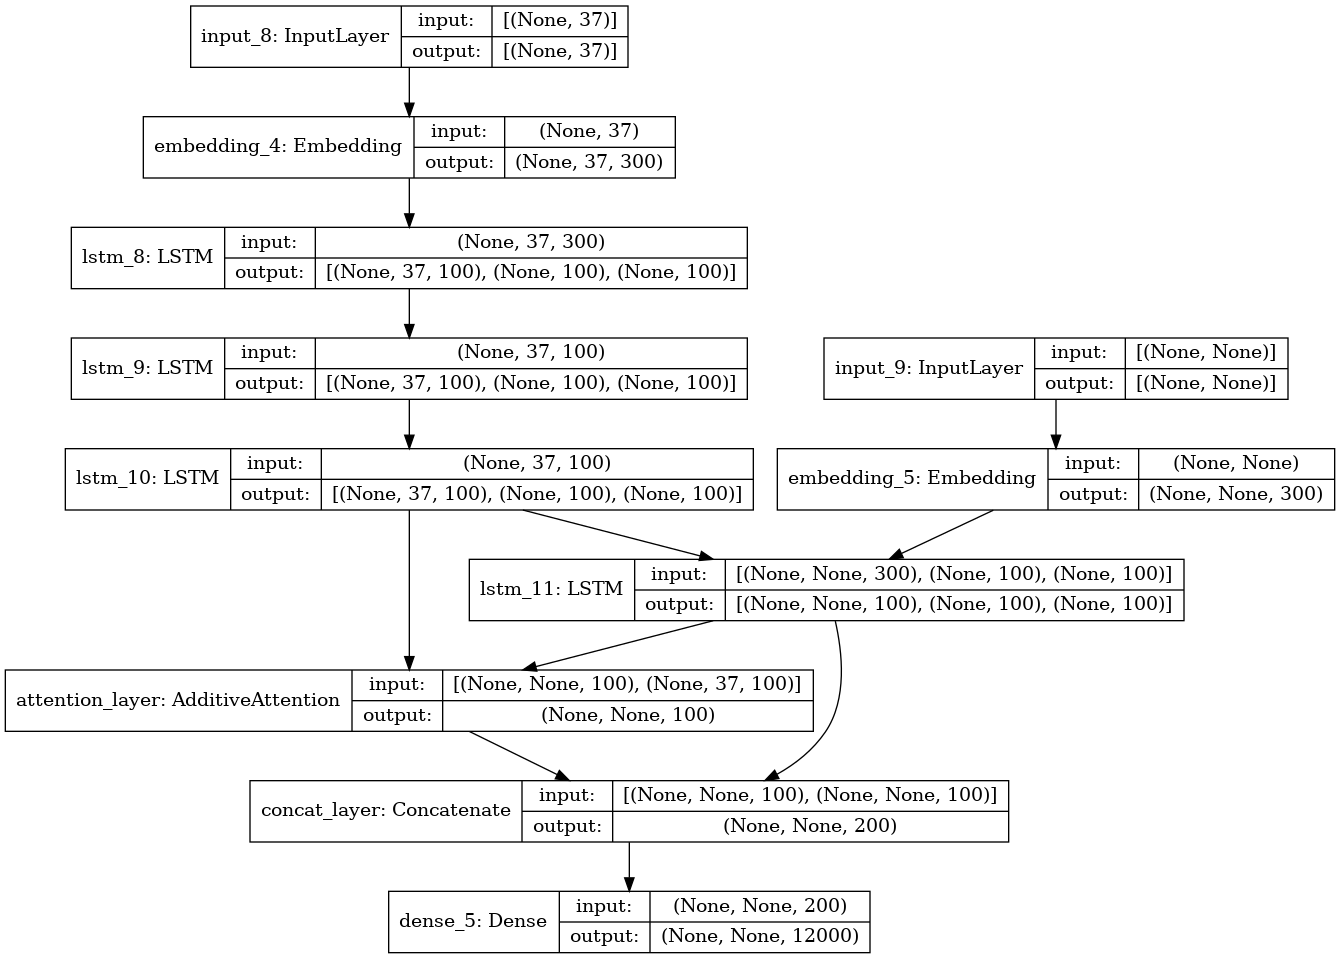

In [65]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', patience=40, verbose=1,mode='max')

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=200)

Epoch 1/200
64/64 [==============================] - 42s 541ms/step - loss: 7.2581 - accuracy: 0.1187 - val_loss: 6.8486 - val_accuracy: 0.1305
Epoch 2/200
64/64 [==============================] - 33s 523ms/step - loss: 6.8502 - accuracy: 0.1341 - val_loss: 6.7601 - val_accuracy: 0.1311
Epoch 3/200
64/64 [==============================] - 33s 523ms/step - loss: 6.7903 - accuracy: 0.1352 - val_loss: 6.7378 - val_accuracy: 0.1312
Epoch 4/200
64/64 [==============================] - 33s 519ms/step - loss: 6.7545 - accuracy: 0.1362 - val_loss: 6.7231 - val_accuracy: 0.1312
Epoch 5/200
64/64 [==============================] - 33s 523ms/step - loss: 6.7242 - accuracy: 0.1370 - val_loss: 6.7379 - val_accuracy: 0.1307
Epoch 6/200
64/64 [==============================] - 33s 523ms/step - loss: 6.6958 - accuracy: 0.1390 - val_loss: 6.7200 - val_accuracy: 0.1306
Epoch 7/200
64/64 [==============================] - 33s 522ms/step - loss: 6.6675 - accuracy: 0.1414 - val_loss: 6.7472 - val_accuracy:

In [67]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


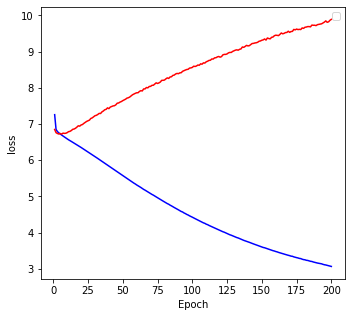

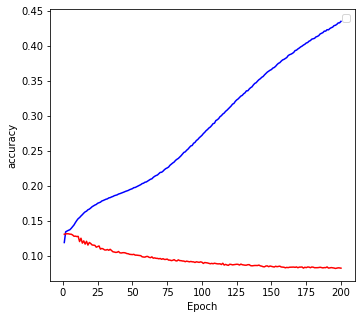

In [68]:
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1,len(loss)+1)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs,loss,color="blue")
ax1.plot(epochs,val_loss,color="red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("loss")
ax1.legend()


#acc and val acc
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

epochs = range(1,len(acc)+1)

fig = plt.figure(figsize=(12,5))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs,acc,color="blue")
ax2.plot(epochs,val_acc,color="red")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("accuracy")
ax2.legend()


plt.show()


In [88]:
model.evaluate([encoder_input_test, decoder_input_test], decoder_target_test)

256/256 [==============================] - 10s 41ms/step - loss: 9.8929 - accuracy: 0.0820


[9.892901420593262, 0.0820128470659256]

In [89]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


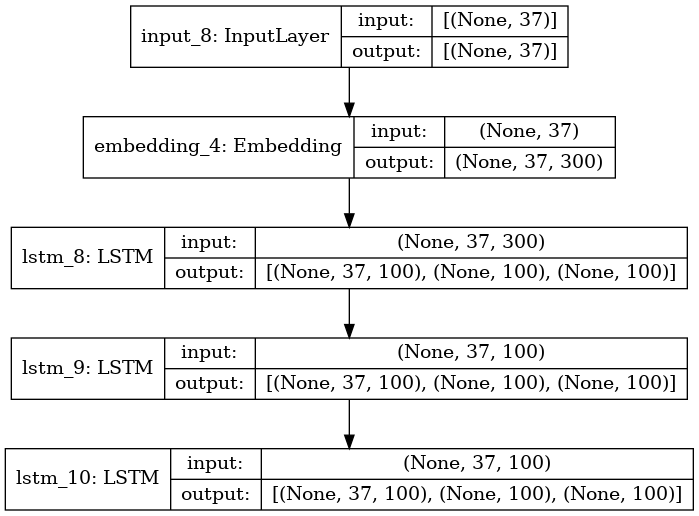

In [90]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

tf.keras.utils.plot_model(encoder_model,show_shapes=True)

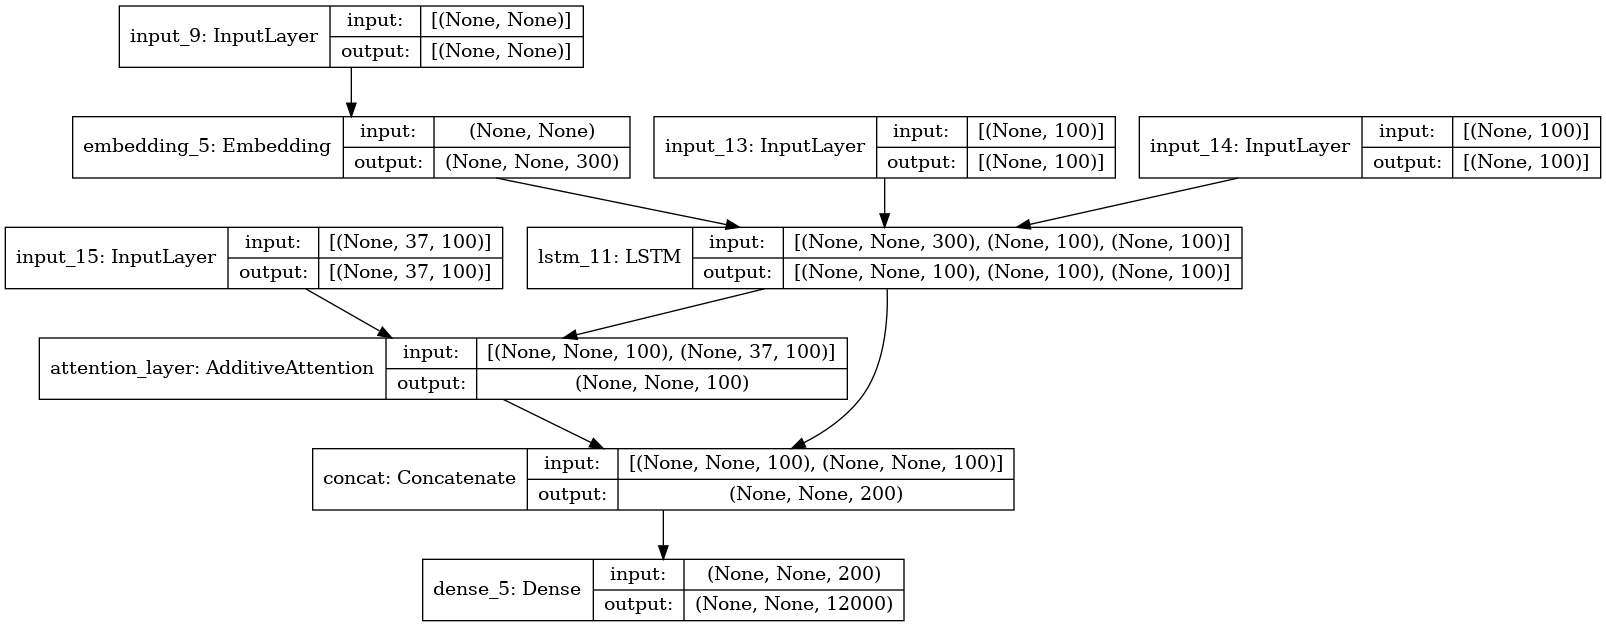

In [91]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

tf.keras.utils.plot_model(decoder_model,show_shapes=True)

In [92]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [93]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [94]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


원문 : singer garg sentenced months jail penalty assault case arrested pertaining case allegedly slapped son advocate smoking public lawyer said accepted judgment respect planned appeal higher court 
실제 요약 : what is the history of international women day 
예측 요약 :  class plans falls falls falls day by day


원문 : iraq friday banned international flights kurdistan region retaliatory measure region held independence referendum however officials said humanitarian military flights exempt ban iraqi kurds voted independence iraq despite claims government would cause instability threaten country unity 
실제 요약 : bengaluru to get vehicle charging stations 
예측 요약 :  better better of during better during during


원문 : winners year wimbledon men singles women singles events get prize money runners receive winning pairs men women doubles events get respectively winning mixed doubles pair receive 
실제 요약 : hyderabad man booked for giving triple talaq on phone 
예측 요약 :  killed profit in in after in in quar

# extract text summarize 

In [95]:
import requests
from summa.summarizer import summarize

In [97]:
text = []
model_output =[]
for i in range(50, 100):
    text.append(seq2summary(decoder_input_test[i]))
    model_output.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

len(text)

50

In [104]:
for i in range(1, 50):
    print('Summary:',i," ",end=" ")
    print(summarize(text[i], ratio=0.05))
    print()

Summary: 1   

Summary: 2   

Summary: 3   

Summary: 4   

Summary: 5   

Summary: 6   

Summary: 7   

Summary: 8   

Summary: 9   

Summary: 10   

Summary: 11   

Summary: 12   

Summary: 13   

Summary: 14   

Summary: 15   

Summary: 16   

Summary: 17   

Summary: 18   

Summary: 19   

Summary: 20   

Summary: 21   

Summary: 22   

Summary: 23   

Summary: 24   

Summary: 25   

Summary: 26   

Summary: 27   

Summary: 28   

Summary: 29   

Summary: 30   

Summary: 31   

Summary: 32   

Summary: 33   

Summary: 34   

Summary: 35   

Summary: 36   

Summary: 37   

Summary: 38   

Summary: 39   

Summary: 40   

Summary: 41   

Summary: 42   

Summary: 43   

Summary: 44   

Summary: 45   

Summary: 46   

Summary: 47   

Summary: 48   

Summary: 49   



# 평가 하기 

blue score , ROUGE score 

In [100]:
!pip install rouge 


In [101]:
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu

rouge=Rouge()
rouge.get_scores(model_output, text, avg=True)

{'rouge-1': {'r': 0.035238095238095235,
  'p': 0.056571428571428564,
  'f': 0.04265201334052489},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.035238095238095235,
  'p': 0.056571428571428564,
  'f': 0.04265201334052489}}

In [105]:
print(sentence_bleu(text, model_output, weights=(0.25, 0.25, 0.25, 0.25)))

0


# 회고 


Attention 구조   
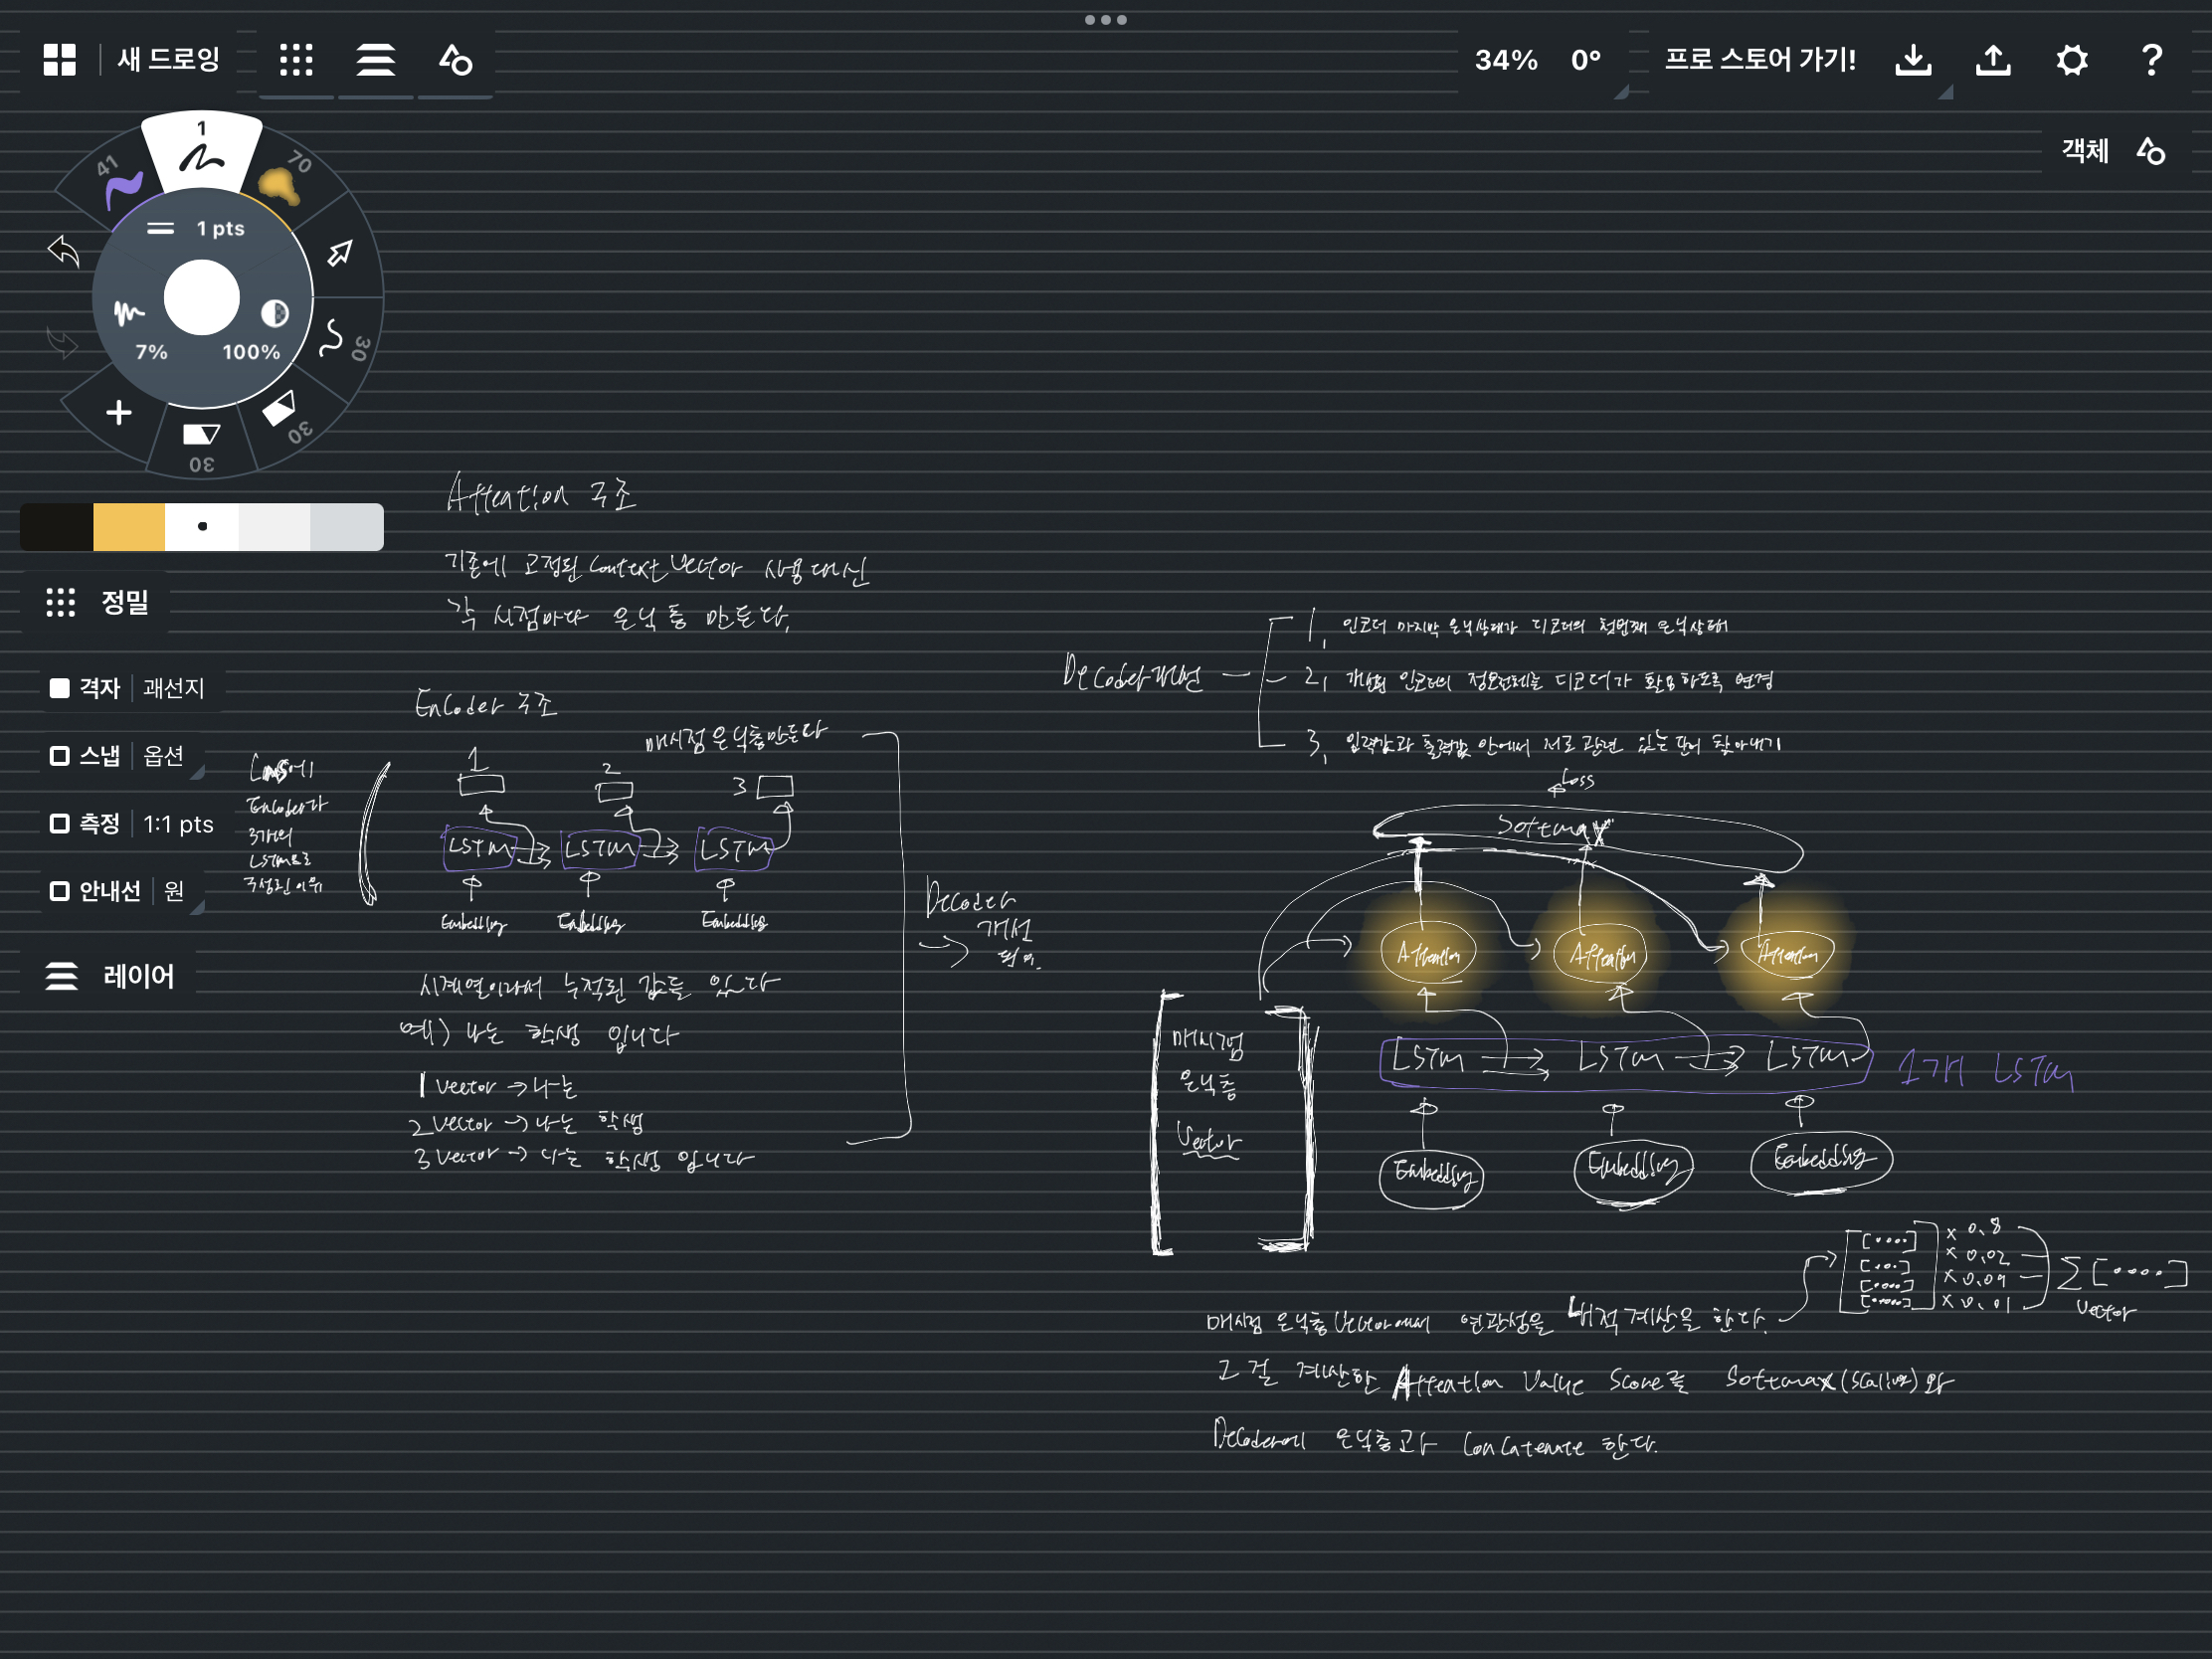  
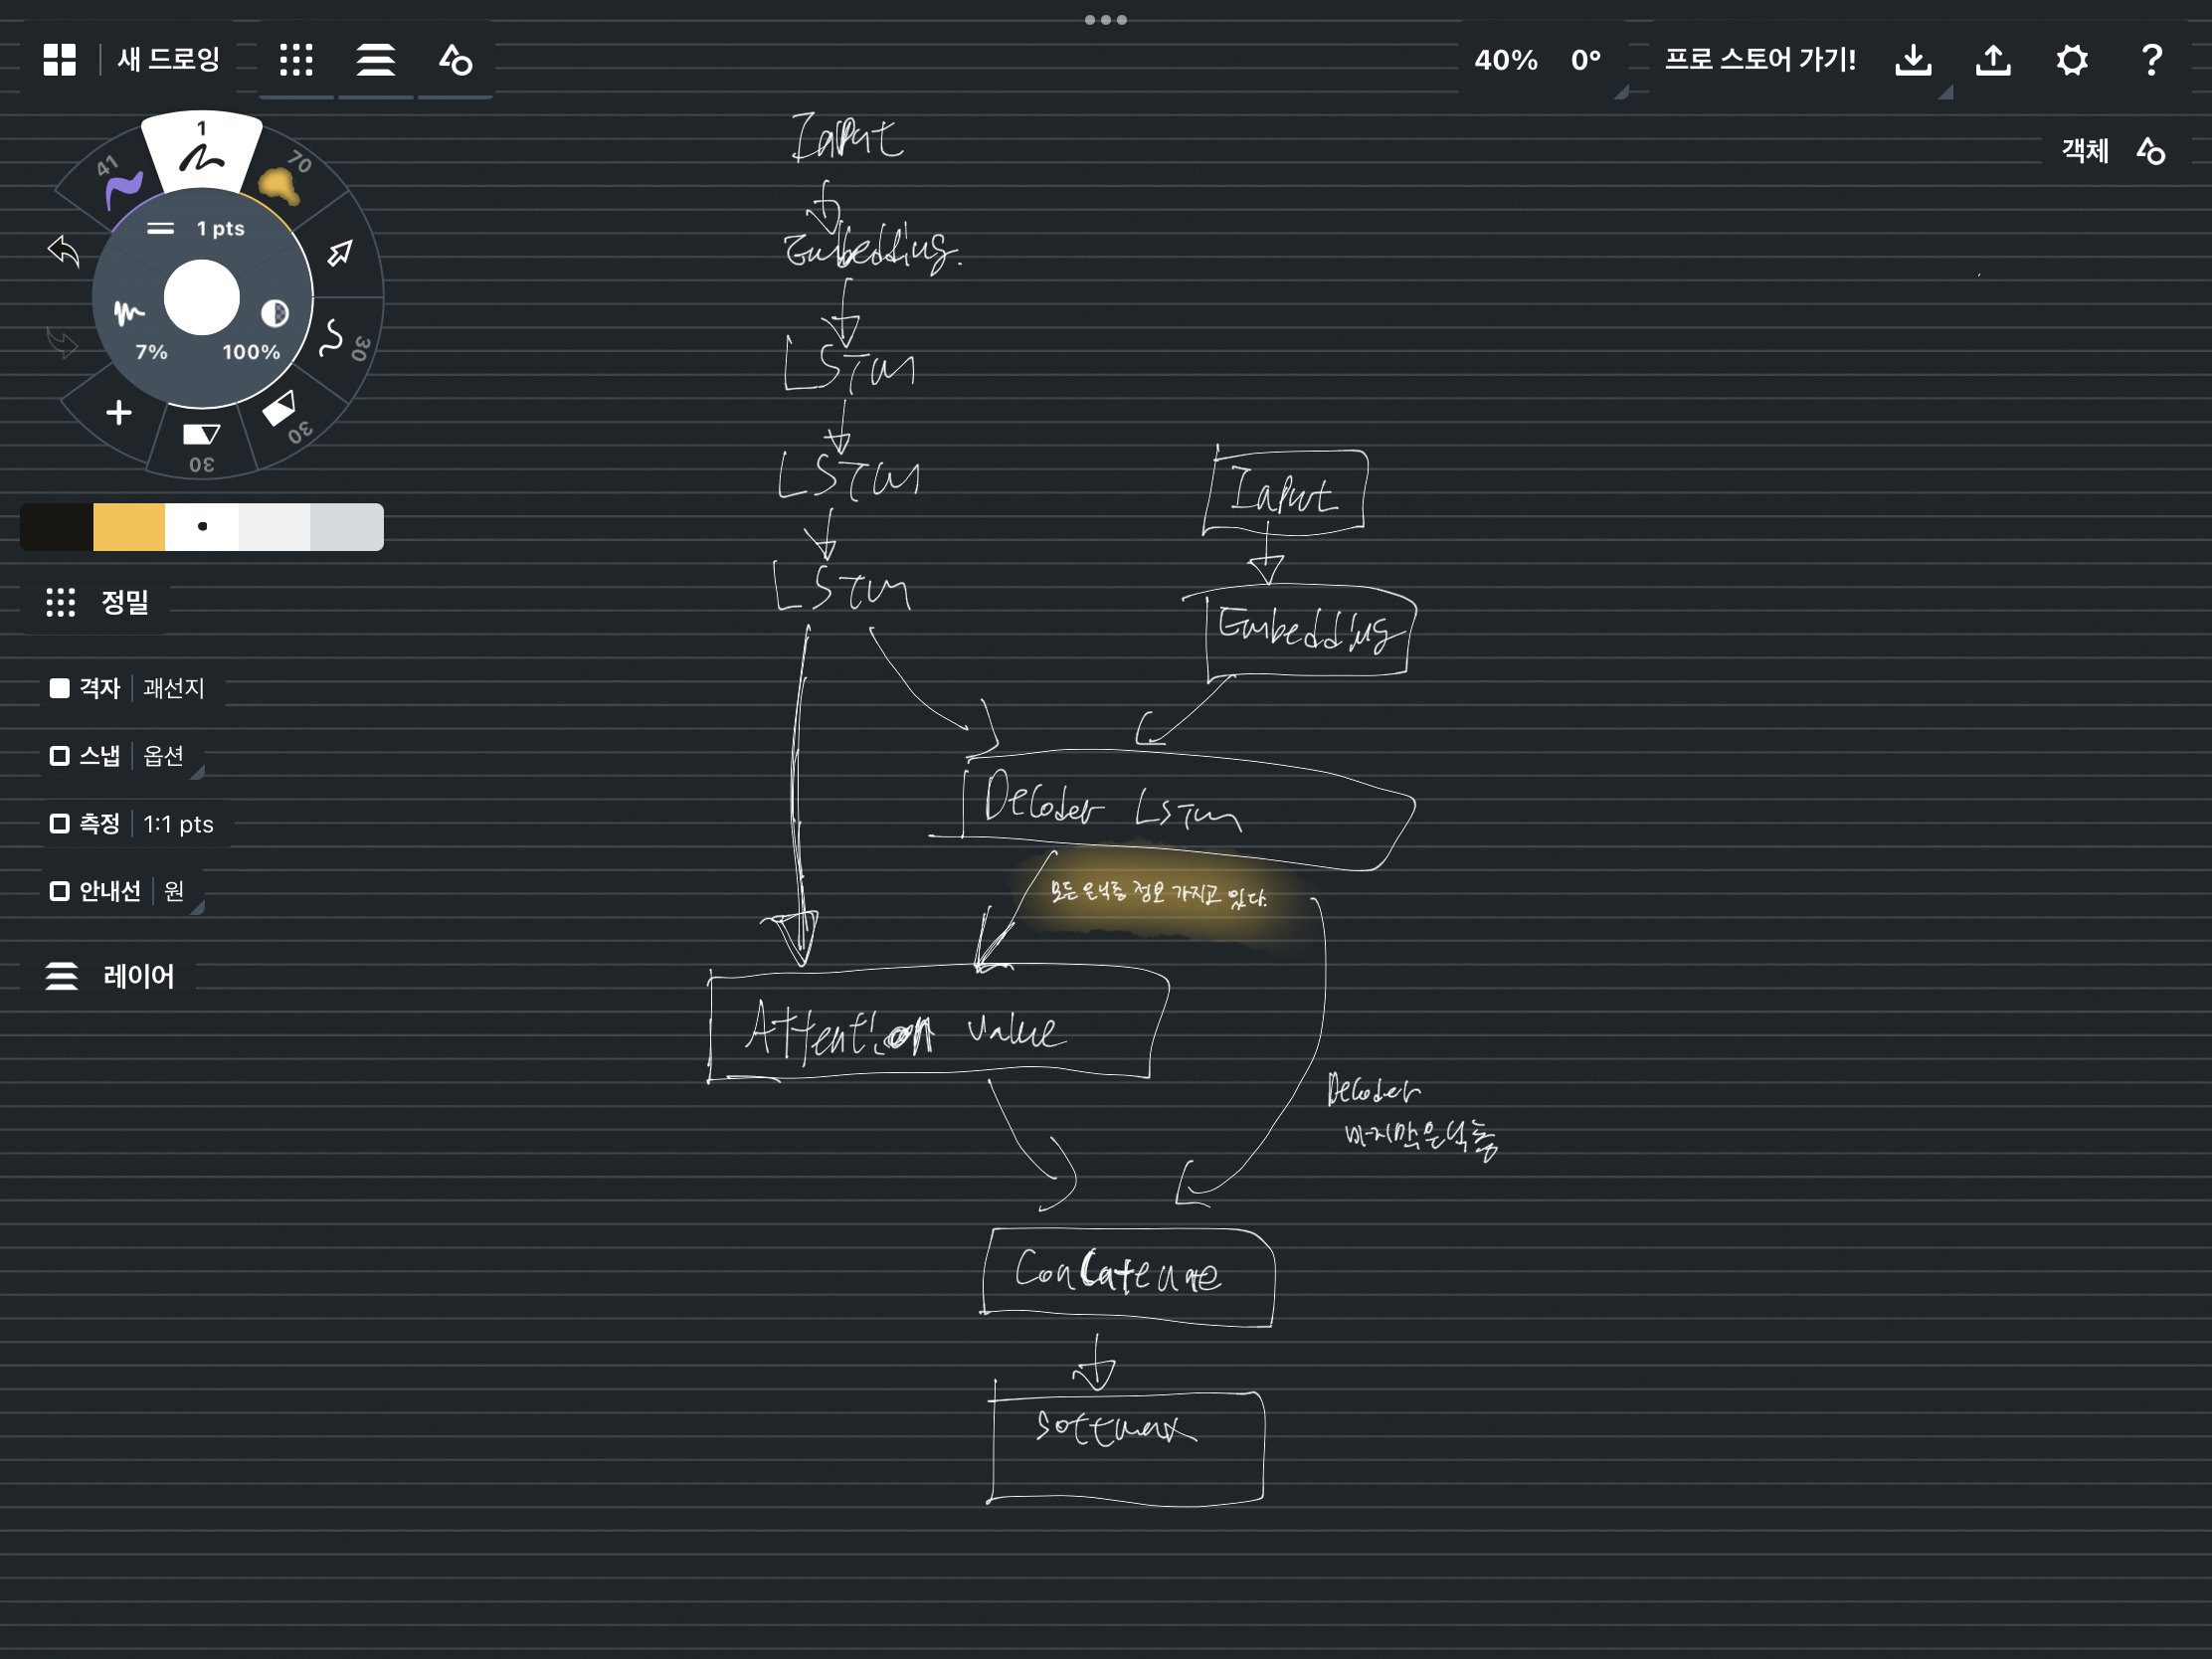  
  
  
  
  
Rouge score (recall oriented understudy for gisting evaluation )

label과 모델이 생성한것 비교해서 성능 비교를 하고 여러가지 지표가 있다  
대표적으로 recall, precision,LCS가 있다 

recall은 label을 구성하는 단어중 몇개가 겹치는가 우선적으로 필요한 정보들이 다 담겨 있는지 확인한다 

precision은 요약된 문장에 필요한 정보만을 얼마나 담고 있는지 확인하는데 모델을 구성하는 단어중 몇개가 label과 겹치는지 확인한다   

LCS : 순서를 따진다 

다만 문법적인 오류나 일관성등은 전혀 판단 할수없었다 
Rouge 2.0버전: 동의어 반영하는등 개선점이 나왔지만 여전히 아쉬운 부분이 있다   


Blue score 
또다른 평가 지표이다  

n gram기반으로 번역한 문장이 실제 문장과 비교했을때 얼마나 비슷한지 평가하는 지표이다 

시간이 너무 오래 걸려서 많이 실험을 하지 못한게 조금 아쉽다  

생각 보다 성능이 잘 안나와서 계속 시도해봣는데 아쉽다  
